In [1]:
import sys
sys.path.append("../")

In [2]:
import pandas as pd
import datetime as dt
from technicals.indicators import MACD
from technicals.patterns import apply_patterns
from simulation.guru_tester import GuruTester
from ploting import CandlePlot
import plotly.graph_objects as go

In [3]:
BUY = 1
SELL = -1
NONE = 0

    
def apply_signal(row):
    if row.direction == BUY and row.mid_l > row.EMA_100 and row.candle_dir == BUY:
        return BUY
    if row.direction == SELL and row.mid_h < row.EMA_100 and  row.candle_dir == SELL:
        return SELL
    return NONE        

In [5]:
pair="EUR_USD"
df_an = pd.read_pickle(f"../data/{pair}_H1.pkl")
df_m5 = pd.read_pickle(f"../data/{pair}_M5.pkl")
df_an.reset_index(drop=True, inplace=True)
df_m5.reset_index(drop=True, inplace=True)

In [6]:
df_an=MACD(df_an)
df_an["EMA_100"]=df_an.mid_c.ewm(span=100, min_periods=100).mean()
df_an.dropna(inplace=True)
df_an.reset_index(drop=True, inplace=True)
df_an.head()

,time,volume,mid_o,mid_h,mid_l,mid_c,bid_o,bid_h,bid_l,bid_c,ask_o,ask_h,ask_l,ask_c,MACD,SIGNAL,HIST,EMA_100
0,2018-04-13 00:00:00+00:00,1157,1.23290,1.23327,1.23262,1.23282,1.23284,1.23320,1.23255,1.23276,1.23297,1.23334,1.23270,1.23289,0.000684,0.000748,-0.000064,1.234245
1,2018-04-13 01:00:00+00:00,1221,1.23282,1.23313,1.23218,1.23232,1.23275,1.23306,1.23211,1.23226,1.23290,1.23320,1.23225,1.23239,0.000678,0.000734,-0.000056,1.234201
2,2018-04-13 02:00:00+00:00,774,1.23228,1.23307,1.23215,1.23293,1.23221,1.23299,1.23208,1.23287,1.23235,1.23315,1.23222,1.23299,0.000631,0.000713,-0.000083,1.234172
3,2018-04-13 03:00:00+00:00,584,1.23292,1.23336,1.23274,1.23299,1.23285,1.23329,1.23266,1.23292,1.23300,1.23344,1.23281,1.23306,0.000583,0.000687,-0.000104,1.234145
4,2018-04-13 04:00:00+00:00,148,1.23304,1.23306,1.23276,1.23292,1.23297,1.23298,1.23270,1.23286,1.23311,1.23313,1.23283,1.23299,0.000542,0.000658,-0.000116,1.234118


In [7]:
def apply_cross(row):
    if row.macd_delta>0 and row.macd_delta_prev<0:
        return BUY
    if row.macd_delta<0 and row.macd_delta_prev>0:
        return SELL
    
    return NONE

In [9]:
df_an["macd_delta"]=df_an.MACD - df_an.SIGNAL
df_an["macd_delta_prev"]=df_an.macd_delta.shift(1)
df_an["direction"]=df_an.apply(apply_cross,axis=1)
candle_dir=df_an.mid_c-df_an.mid_o
df_an['candle_dir']= [BUY if x>=0 else SELL for x in candle_dir]

In [8]:
df_an.direction.value_counts()

direction
 0    34414
 1     1410
-1     1410
Name: count, dtype: int64

In [12]:
def run_pair(pair,time_d=1):
    df_an = pd.read_pickle(f"../data/{pair}_H{time_d}.pkl")
    df_m5 = pd.read_pickle(f"../data/{pair}_M5.pkl")
    df_an.reset_index(drop=True, inplace=True)
    df_m5.reset_index(drop=True, inplace=True)
    df_an = MACD(df_an)
    df_an['EMA_100'] = df_an.mid_c.ewm(span=100, min_periods=100).mean()
    df_an["macd_delta"]=df_an.MACD-df_an.SIGNAL
    df_an["macd_delta_prev"]=df_an.macd_delta.shift(1)
    df_an["direction"]=df_an.apply(apply_cross,axis=1)
    candle_dir=df_an.mid_c-df_an.mid_o
    df_an['candle_dir']= [BUY if x>=0 else SELL for x in candle_dir]
    our_cols = ['time', 'mid_o', 'mid_h', 'mid_l', 'mid_c',
            'bid_o', 'bid_h', 'bid_l', 'bid_c', 
            'ask_o', 'ask_h', 'ask_l', 'ask_c'
            , 'direction', 'EMA_100','candle_dir'  ]
    df_slim = df_an[our_cols].copy()
    df_slim.dropna(inplace=True)
    
    df_slim.reset_index(drop=True, inplace=True)
    gt = GuruTester(
        df_slim,
        apply_signal,
        df_m5,
        use_spread=True,
        time_d=time_d
    )
    
    gt.run_test()
    return gt.df_results
    

In [14]:
res = []
for p in [ "EUR_USD", "EUR_GBP" ]:
    res.append(dict(pair=p,res=run_pair(p,time_d=4)))

In [15]:
for r in res:
    print(r['pair'], r['res'].result.sum())

EUR_USD -13.0
EUR_GBP -23.0


In [69]:
print(res[0]['pair'])
an=pd.DataFrame.from_dict(res[0]['res'])
an[an.result==-1.0]

EUR_USD


,running,start_index_m5,profit_factor,loss_factor,start_price,trigger_price,SIGNAL,TP,SL,result,end_time,start_time
3,False,2297,1.5,-1.0,1.23716,1.23716,1,1.237880,1.23753,-1.0,2018-04-18 21:00:00+00:00,2018-04-18 21:00:00+00:00
5,False,2897,1.5,-1.0,1.22809,1.22819,-1,1.227710,1.22806,-1.0,2018-04-22 23:00:00+00:00,2018-04-22 23:00:00+00:00
10,False,4935,1.5,-1.0,1.19914,1.19943,-1,1.198955,1.19903,-1.0,2018-05-02 01:00:00+00:00,2018-05-02 01:00:00+00:00
13,False,6012,1.5,-1.0,1.19252,1.19264,-1,1.192075,1.19260,-1.0,2018-05-07 19:10:00+00:00,2018-05-07 19:00:00+00:00
14,False,6345,1.5,-1.0,1.18606,1.18632,-1,1.185795,1.18602,-1.0,2018-05-08 23:00:00+00:00,2018-05-08 23:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
1236,False,437108,1.5,-1.0,1.08092,1.08060,1,1.081085,1.08106,-1.0,2024-02-21 00:00:00+00:00,2024-02-21 00:00:00+00:00
1241,False,439160,1.5,-1.0,1.08191,1.08220,-1,1.081270,1.08207,-1.0,2024-03-01 03:05:00+00:00,2024-03-01 03:00:00+00:00
1243,False,439652,1.5,-1.0,1.08558,1.08558,1,1.085775,1.08570,-1.0,2024-03-04 20:00:00+00:00,2024-03-04 20:00:00+00:00
1254,False,444812,1.5,-1.0,1.08000,1.08024,-1,1.079560,1.08006,-1.0,2024-03-28 17:00:00+00:00,2024-03-28 17:00:00+00:00


                          time  volume    mid_o   mid_h    mid_l    mid_c  \
1353 2018-04-13 14:00:00+00:00     278  1.23246  1.2331  1.23242  1.23294   

        bid_o    bid_h    bid_l    bid_c    ask_o    ask_h    ask_l  ask_c  
1353  1.23235  1.23304  1.23231  1.23288  1.23256  1.23316  1.23253  1.233  


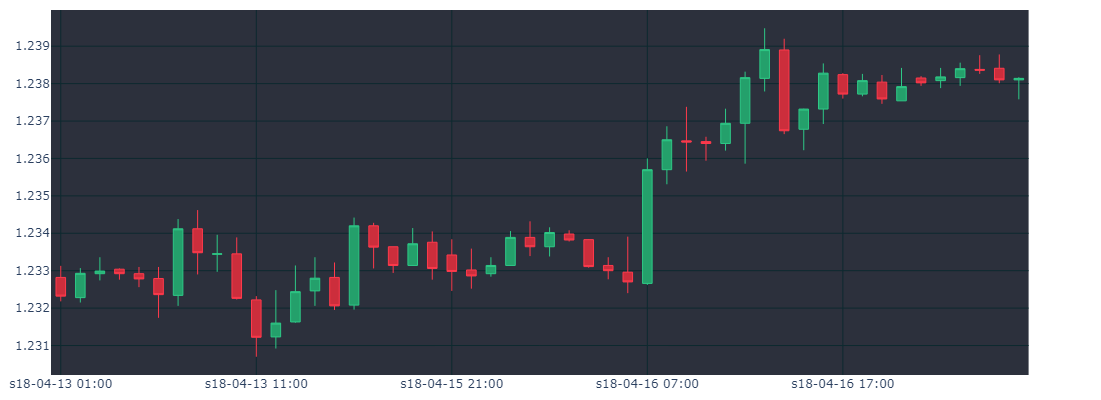

In [66]:
print(df_m5[df_m5.index==1353])
df_plot=df_an.iloc[100:150]
cp=CandlePlot(df_plot, candles=True)

cp.show_plot()